In [1]:
import cv2
import os

# Emotion video sources
video_paths = {
    "happy": "/content/happy.mp4",
    "sad": "/content/sad.mp4",
    "surprise": "/content/surprise.mp4"
}

# Output directory
output_dir = "/content/personal_faces"
os.makedirs(output_dir, exist_ok=True)

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Frame interval (e.g., every 5 frames)
frame_interval = 5

for emotion, path in video_paths.items():
    cap = cv2.VideoCapture(path)
    count = 0
    saved = 0
    save_path = os.path.join(output_dir, emotion)
    os.makedirs(save_path, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

            for i, (x, y, w, h) in enumerate(faces):
                face = frame[y:y+h, x:x+w]
                face = cv2.resize(face, (224, 224))
                filename = f"{emotion}_{saved:04d}.jpg"
                cv2.imwrite(os.path.join(save_path, filename), face)
                saved += 1

        count += 1

    cap.release()
    print(f"✅ {emotion} done: {saved} faces saved.")

print("🎉 All videos processed!")


✅ happy done: 67 faces saved.
✅ sad done: 109 faces saved.
✅ surprise done: 61 faces saved.
🎉 All videos processed!


In [2]:
import os
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

# 原始與目標資料夾
input_root = "/content/personal_faces"
output_root = "/content/personal_faces_augmented"

# 定義增強操作（每張圖產生 3 張）
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.Resize((224, 224))
])

# 建立輸出資料夾
os.makedirs(output_root, exist_ok=True)

# 開始增強每一類情緒
for emotion in os.listdir(input_root):
    input_dir = os.path.join(input_root, emotion)
    output_dir = os.path.join(output_root, emotion)
    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in tqdm(image_files, desc=f"🔁 Augmenting {emotion}"):
        img_path = os.path.join(input_dir, file)
        img = Image.open(img_path).convert("RGB")

        # 存原圖
        img.resize((224, 224)).save(os.path.join(output_dir, file))

        # 存增強圖
        for i in range(1, 4):  # 3 augmented versions
            augmented = augmentations(img)
            new_filename = f"{os.path.splitext(file)[0]}_aug{i}.jpg"
            augmented.save(os.path.join(output_dir, new_filename))

print("✅ Data augmentation complete! Augmented images saved to /content/personal_faces_augmented/")


🔁 Augmenting surprise: 100%|██████████| 61/61 [00:00<00:00, 146.63it/s]

✅ Data augmentation complete! Augmented images saved to /content/personal_faces_augmented/


In [4]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

# 設定路徑
data_dir = "/content/personal_faces_augmented"
pretrained_model_path = "/content/raf-db_efficientnet_b0.pth"
save_path = "/content/models/efficientnet/personal_transfer.pth"

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 資料轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 載入資料
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 建立模型 & 替換分類頭
model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))

# 載入 feature extractor 的預訓練參數（跳過 classifier）
state_dict = torch.load(pretrained_model_path)
model.load_state_dict({k: v for k, v in state_dict.items() if 'classifier.1' not in k}, strict=False)

model = model.to(device)

# 訓練設定
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# 訓練
model.train()
for epoch in range(5):
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/5]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item(), acc=correct/total)

# 儲存
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")


Epoch [5/5]: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s, acc=0.999, loss=0.00814]

✅ Model saved to /content/models/efficientnet/personal_transfer.pth


✅ Device: cuda
✅ happy done: 46 faces saved.
✅ sad done: 57 faces saved.
✅ surprise done: 26 faces saved.

✅ Accuracy: 0.5978
✅ F1 Score: 0.5671

📋 Classification Report:
               precision    recall  f1-score   support

       happy       0.61      0.90      0.73        92
         sad       1.00      0.30      0.46       132
    surprise       0.42      0.83      0.56        52

    accuracy                           0.60       276
   macro avg       0.68      0.67      0.58       276
weighted avg       0.76      0.60      0.57       276



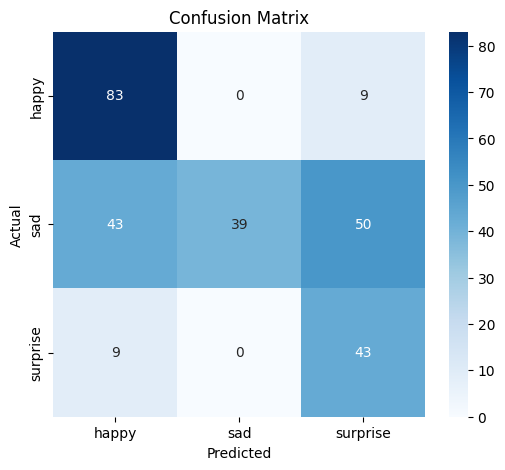

In [7]:
# ✅ 驗證流程：擷取影片 → 增強影像 → 載入模型 → 評估效能
import os, cv2, torch, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
import torch.nn as nn
from torchvision.transforms import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# -------------------- Step 1: 擷取影片中的臉部 --------------------
video_paths = {
    "happy": "/content/happy_val.mp4",
    "sad": "/content/sad_val.mp4",
    "surprise": "/content/surprise_val.mp4"
}
raw_dir = "/content/validation_faces_raw"
os.makedirs(raw_dir, exist_ok=True)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emotion, video_path in video_paths.items():
    save_dir = os.path.join(raw_dir, emotion)
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_id, count = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame_id += 1
        if frame_id % 5 != 0: continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            face = cv2.resize(frame[y:y+h, x:x+w], (224, 224))
            cv2.imwrite(os.path.join(save_dir, f"{count}.jpg"), face)
            count += 1
    cap.release()
    print(f"✅ {emotion} done: {count} faces saved.")

# -------------------- Step 2: 資料增強 --------------------
aug_dir = "/content/validation_faces_augmented"
os.makedirs(aug_dir, exist_ok=True)
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])
for class_name in os.listdir(raw_dir):
    in_dir = os.path.join(raw_dir, class_name)
    out_dir = os.path.join(aug_dir, class_name)
    os.makedirs(out_dir, exist_ok=True)
    for img_name in os.listdir(in_dir):
        img_path = os.path.join(in_dir, img_name)
        img = Image.open(img_path)
        for i in range(2):  # 原圖 + 2張增強圖
            aug_img = augmentations(img)
            F.to_pil_image(aug_img).save(os.path.join(out_dir, f"{img_name[:-4]}_aug{i}.jpg"))

# -------------------- Step 3: 載入模型並評估 --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = ImageFolder(aug_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model_path = "/content/models/efficientnet/personal_transfer.pth"
model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# -------------------- Step 4: 輸出結果 --------------------
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"\n✅ Accuracy: {acc:.4f}\n✅ F1 Score: {f1:.4f}")
print("\n📋 Classification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
